In [1]:
import sys
sys.path.append('C:\\Users\\Yonatan Gideoni\\Desktop\\ML4Q\\c3')

Code mostly taken from <code>two_qubits.ipynb</code> and <code>two_qubits_entangling_gate.ipynb</code>

#### Imports

In [2]:
# System imports
import copy
import itertools
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pandas as pd
import scipy.interpolate
import tensorflow as tf
from typing import List
from pprint import pprint
import pickle

# Main C3 objects
from c3.c3objs import Quantity as Qty
from c3.parametermap import ParameterMap as PMap
from c3.experiment import Experiment as Exp
from c3.model import Model as Mdl
from c3.generator.generator import Generator as Gnr

# Building blocks
import c3.generator.devices as devices
import c3.signal.gates as gates
import c3.libraries.chip as chip
import c3.signal.pulse as pulse
import c3.libraries.tasks as tasks

# Libs and helpers
import c3.libraries.algorithms as algorithms
import c3.libraries.hamiltonians as hamiltonians
import c3.libraries.fidelities as fidelities
import c3.libraries.envelopes as envelopes

# Qiskit related modules
from c3.qiskit import C3Provider
from c3.qiskit.c3_gates import RX90pGate
from qiskit import QuantumCircuit, Aer, execute
from qiskit.tools.visualization import plot_histogram

#### Model components

In [3]:
qubit_lvls = 3
freq_q1 = 5e9
anhar_q1 = -210e6
t1_q1 = 27e-6
t2star_q1 = 39e-6
qubit_temp = 50e-3

q1 = chip.Qubit(
    name="Q1",
    desc="Qubit 1",
    freq=Qty(
        value=freq_q1,
        min_val=4.995e9 ,
        max_val=5.005e9 ,
        unit='Hz 2pi'
    ),
    anhar=Qty(
        value=anhar_q1,
        min_val=-380e6 ,
        max_val=-120e6 ,
        unit='Hz 2pi'
    ),
    hilbert_dim=qubit_lvls,
    t1=Qty(
        value=t1_q1,
        min_val=1e-6,
        max_val=90e-6,
        unit='s'
    ),
    t2star=Qty(
        value=t2star_q1,
        min_val=10e-6,
        max_val=90e-3,
        unit='s'
    ),
    temp=Qty(
        value=qubit_temp,
        min_val=0.0,
        max_val=0.12,
        unit='K'
    )
)

In [4]:
freq_q2 = 5.6e9
anhar_q2 = -240e6
t1_q2 = 23e-6
t2star_q2 = 31e-6
q2 = chip.Qubit(
    name="Q2",
    desc="Qubit 2",
    freq=Qty(
        value=freq_q2,
        min_val=5.595e9 ,
        max_val=5.605e9 ,
        unit='Hz 2pi'
    ),
    anhar=Qty(
        value=anhar_q2,
        min_val=-380e6 ,
        max_val=-120e6 ,
        unit='Hz 2pi'
    ),
    hilbert_dim=qubit_lvls,
    t1=Qty(
        value=t1_q2,
        min_val=1e-6,
        max_val=90e-6,
        unit='s'
    ),
    t2star=Qty(
        value=t2star_q2,
        min_val=10e-6,
        max_val=90e-6,
        unit='s'
    ),
    temp=Qty(
        value=qubit_temp,
        min_val=0.0,
        max_val=0.12,
        unit='K'
    )
)

In [5]:
coupling_strength = 50e6
q1q2 = chip.Coupling(
    name="Q1-Q2",
    desc="coupling",
    comment="Coupling qubit 1 to qubit 2",
    connected=["Q1", "Q2"],
    strength=Qty(
        value=coupling_strength,
        min_val=-1 * 1e3 ,
        max_val=200e6 ,
        unit='Hz 2pi'
    ),
    hamiltonian_func=hamiltonians.int_XX
)

drive = chip.Drive(
    name="d1",
    desc="Drive 1",
    comment="Drive line 1 on qubit 1",
    connected=["Q1"],
    hamiltonian_func=hamiltonians.x_drive
)
drive2 = chip.Drive(
    name="d2",
    desc="Drive 2",
    comment="Drive line 2 on qubit 2",
    connected=["Q2"],
    hamiltonian_func=hamiltonians.x_drive
)

We collect the parts specified above in the Model.

In [6]:
model = Mdl(
    [q1, q2], # Individual, self-contained components
    [drive, drive2, q1q2],  # Interactions between components
)

Further, we can decide between coherent or open-system dynamics using set_lindbladian() and whether to eliminate the static coupling by going to the dressed frame with set_dressed().

In [7]:
model.set_lindbladian(False)
model.set_dressed(True)

#### Control signals

In [8]:
sim_res = 100e9 # Resolution for numerical simulation
awg_res = 2e9 # Realistic, limited resolution of an AWG
lo = devices.LO(name='lo', resolution=sim_res)
awg = devices.AWG(name='awg', resolution=awg_res)
mixer = devices.Mixer(name='mixer')

In [9]:
dig_to_an = devices.DigitalToAnalog(
    name="dac",
    resolution=sim_res
)
v2hz = 1e9
v_to_hz = devices.VoltsToHertz(
    name='v_to_hz',
    V_to_Hz=Qty(
        value=v2hz,
        min_val=0.9e9,
        max_val=1.1e9,
        unit='Hz/V'
    )
)

The generator combines the parts of the signal generation and assignes a signal chain to each control line.

In [10]:
generator = Gnr(
        devices={
            "LO": devices.LO(name='lo', resolution=sim_res, outputs=1),
            "AWG": devices.AWG(name='awg', resolution=awg_res, outputs=1),
            "DigitalToAnalog": devices.DigitalToAnalog(
                name="dac",
                resolution=sim_res,
                inputs=1,
                outputs=1
            ),
            "Mixer": devices.Mixer(name='mixer', inputs=2, outputs=1),
            "VoltsToHertz": devices.VoltsToHertz(
                name='v_to_hz',
                V_to_Hz=Qty(
                    value=1e9,
                    min_val=0.9e9,
                    max_val=1.1e9,
                    unit='Hz/V'
                ),
                inputs=1,
                outputs=1
            )
        },
        chains= {
            "d1": {
                "LO": [],
                "AWG": [],
                "DigitalToAnalog": ["AWG"],
                "Mixer": ["LO", "DigitalToAnalog"],
                "VoltsToHertz": ["Mixer"]
            },
            "d2": {
                "LO": [],
                "AWG": [],
                "DigitalToAnalog": ["AWG"],
                "Mixer": ["LO", "DigitalToAnalog"],
                "VoltsToHertz": ["Mixer"]
            },
        }
    )

#### Gates-set and Parameter map

In [11]:
t_final = 45e-9 # 7e-9   # Time for single qubit gates
t_final_2Q = 45e-9 # Time for two qubit gates
sideband = 50e6 

In [12]:
def_params = {
    'amp': Qty(
        value=1.,
        min_val=0.0,
        max_val=100.,
        unit="V"
    ),
    't_final': Qty(
        value=t_final,
        min_val=0.5 * t_final,
        max_val=1.5 * t_final,
        unit="s"
    ),
    'xy_angle': Qty(
        value=0.0,
        min_val=-0.5 * np.pi,
        max_val=2.5 * np.pi,
        unit='rad'
    ),
    'freq_offset': Qty(
        value=-sideband - 3e6 ,
        min_val=-56 * 1e6 ,
        max_val=-52 * 1e6 ,
        unit='Hz 2pi'
    ),
    'delta': Qty(
        value=-1,
        min_val=-5,
        max_val=3,
        unit=""
    )
}

In [13]:
# gaussiam params
gauss_params = copy.deepcopy(def_params)
gauss_params['sigma'] = Qty(
    value=t_final / 4, 
    min_val=t_final / 8, 
    max_val=t_final / 2, 
    unit="s"
)
gauss_env = pulse.Envelope(
    name="gauss",
    desc="Gaussian comp for single-qubit gates",
    params=gauss_params,
    shape=envelopes.gaussian_nonorm,
    normalize_pulse=True
)

gauss_der_params = copy.deepcopy(gauss_params)
gauss_der_env = pulse.Envelope(
    name="gauss_der",
    desc="Derivative of gaussian comp for single-qubit gates",
    params=gauss_der_params,
    shape=envelopes.gaussian_der_mag_unity,
    normalize_pulse=True
)

left_half_gauss_params = copy.deepcopy(gauss_params)
left_half_gauss_params['t_final'].set_value(t_final * 0.8)
left_half_gauss_env = pulse.Envelope(
    name="left_gauss",
    desc="Left half gaussian comp for single-qubit gates",
    params=left_half_gauss_params,
    shape=envelopes.left_half_gaussian_nonorm,
    normalize_pulse=True
)

right_half_gauss_params = copy.deepcopy(gauss_params)
right_half_gauss_env = pulse.Envelope(
    name="right_gauss",
    desc="Right half gaussian comp for single-qubit gates",
    params=right_half_gauss_params,
    shape=envelopes.right_half_gaussian_nonorm,
    normalize_pulse=True
)

In [14]:
# hann params
hann_params = copy.deepcopy(def_params)
hann_env = pulse.Envelope(
    name="hann",
    desc="Hann comp for single-qubit gates",
    params=hann_params,
    shape=envelopes.hann,
    normalize_pulse=True
)

In [15]:
# blackman params
blackman_params = copy.deepcopy(def_params)

blackman_env = pulse.Envelope(
    name="blackman",
    desc="Blackman comp for single-qubit gates",
    params=blackman_params,
    shape=envelopes.blackman_window,
    normalize_pulse=True
)

In [16]:
signal_type_config = {
    'gauss': (gauss_params, gauss_env), 
    'gauss_der': (gauss_der_params, gauss_der_env), 
    'hann': (hann_params, hann_env),
    'blackman': (blackman_params, blackman_env),
    'left_gauss': (left_half_gauss_params, left_half_gauss_env), 
    'right_gauss': (right_half_gauss_params, right_half_gauss_env), 
}

opt_params_per_sig =  {
    'gauss': ['amp', 'freq_offset', 'xy_angle', 'delta'],
    'gauss_der': ['amp', 'freq_offset', 'xy_angle', 'delta'],
    'hann': ['amp', 'freq_offset', 'xy_angle', 'delta'],
    'blackman': ['amp', 'freq_offset', 'xy_angle', 'delta'],
    'left_gauss': ['amp', 'freq_offset', 'xy_angle', 'delta', 't_final'],
    'right_gauss': ['amp', 'freq_offset', 'xy_angle', 'delta', 't_final'],
}

In [17]:
pulses_per_driver = {
    1: {'gauss': 1, 
        'gauss_der': 0,
        'hann': 0, 
        'blackman': 0, 
        'left_gauss': 0, 
        'right_gauss': 0},
    2: {'gauss': 1, 
        'gauss_der': 0,
        'hann': 0, 
        'blackman': 0, 
        'left_gauss': 0, 
        'right_gauss': 0}}

largest_pulse_v = 30.
smallest_pulse_v = 20.

drivers_signals = []
signals_opt_params = []

for driver, n_pulses_per_type in pulses_per_driver.items():
    for pulse_type, n_pulses in n_pulses_per_type.items():
        for i, voltage in enumerate(np.linspace(smallest_pulse_v, 
                                                largest_pulse_v, 
                                                n_pulses)):
            def_params, def_env = signal_type_config[pulse_type]
            pulse_params = copy.deepcopy(def_params)
            pulse_params['amp'].set_value(voltage)

            envelope = copy.deepcopy(def_env)
            envelope.params = pulse_params
            signals_opt_params.append(opt_params_per_sig[envelope.name])
            envelope.name += str(i)
            drivers_signals.append((driver, envelope))

Carriers:

In [18]:
lo_freq_q1 = freq_q1 + sideband
lo_freq_q2 = freq_q2 + sideband

carr_2Q_1 = pulse.Carrier(
    name="carrier",
    desc="Carrier on drive 1",
    params={
        'freq': Qty(value=lo_freq_q2, min_val=0.9 * lo_freq_q2, max_val=1.1 * lo_freq_q2, unit='Hz 2pi'),
        'framechange': Qty(value=0.0, min_val=-np.pi, max_val=3 * np.pi, unit='rad')
    }
)

carr_2Q_2 = pulse.Carrier(
    name="carrier",
    desc="Carrier on drive 2",
    params={
        'freq': Qty(value=lo_freq_q2, min_val=0.9 * lo_freq_q2, max_val=1.1 * lo_freq_q2, unit='Hz 2pi'),
        'framechange': Qty(value=0.0, min_val=-np.pi, max_val=3 * np.pi, unit='rad')
    }
)

#### Instructions

In [19]:
# CNOT comtrolled by qubit 1
cnot12 = gates.Instruction(
    name="cx", targets=[0, 1], t_start=0.0, t_end=t_final_2Q, channels=["d1", "d2"],
    ideal=np.array([
        [1,0,0,0],
        [0,1,0,0],
        [0,0,0,1],
        [0,0,1,0]
    ])
)

cnot12.add_component(carr_2Q_1, "d1")
cnot12.add_component(carr_2Q_2, "d2")
cnot12.comps["d1"]["carrier"].params["framechange"].set_value(
    (-sideband * t_final_2Q) * 2 * np.pi % (2 * np.pi)
)

Adding each qubit's pulses:

In [20]:
for driver, envelope in drivers_signals:
    cnot12.add_component(envelope, f"d{driver}")

Currently we don't include instructions for single qubit gates.

In [21]:
parameter_map = PMap(instructions=[cnot12], model=model, generator=generator)
exp = Exp(pmap=parameter_map)

#### Dynamics

The system is initialised in the state $|0,1\rangle$ so that a transition to $|1,1\rangle$ should be visible.

In [22]:
psi_init = [[0] * 9]
psi_init[0][1] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
print(init_state)

tf.Tensor(
[[0.+0.j]
 [1.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]], shape=(9, 1), dtype=complex128)


In [23]:
init_state

<tf.Tensor: shape=(9, 1), dtype=complex128, numpy=
array([[0.+0.j],
       [1.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j]])>

In [24]:
gate_name = cnot12.get_key()

Plotting system dynamics and signal:

In [25]:
def plot_dynamics(exp, psi_init, seq, goal=-1):
        """
        Plotting code for time-resolved populations.

        Parameters
        ----------
        psi_init: tf.Tensor
            Initial state or density matrix.
        seq: list
            List of operations to apply to the initial state.
        goal: tf.float64
            Value of the goal function, if used.
        debug: boolean
            If true, return a matplotlib figure instead of saving.
        """
        model = exp.pmap.model
        exp.compute_propagators()
        dUs = exp.partial_propagators
        psi_t = psi_init.numpy()
        pop_t = exp.populations(psi_t, model.lindbladian)
        for gate in seq:
            for du in dUs[gate]:
                psi_t = np.matmul(du.numpy(), psi_t)
                pops = exp.populations(psi_t, model.lindbladian)
                pop_t = np.append(pop_t, pops, axis=1)
        

        fig, axs = plt.subplots(1, 1)
        ts = exp.ts
        dt = ts[1] - ts[0]
        ts = np.linspace(0.0, dt*pop_t.shape[1], pop_t.shape[1]) / 1e-9
        axs.plot(ts, pop_t.T)
        axs.grid(linestyle="--")
        axs.tick_params(
            direction="in", left=True, right=True, top=True, bottom=True
        )
        axs.set_xlabel('Time [ns]')
        axs.set_ylabel('Population')
        
        for state_pop in pops:
            state_pop = state_pop.numpy()[0]
            axs.annotate(f'{state_pop*100:.0f}%', (ts.max(), state_pop))
        
        plt.legend(model.state_labels)
        plt.xlim(0, ts.max() * 1.1)

def get_qubits_population(population: np.array, dims: List[int]) -> np.array:
    """
    Splits the population of all levels of a system into the populations of levels per subsystem.
    Parameters
    ----------
    population: np.array
        The time dependent population of each energy level. First dimension: level index, second dimension: time.
    dims: List[int]
        The number of levels for each subsystem.
    Returns
    -------
    np.array
        The time-dependent population of energy levels for each subsystem. First dimension: subsystem index, second
        dimension: level index, third dimension: time.
    """
    numQubits = len(dims)

    # create a list of all levels
    qubit_levels = []
    for dim in dims:
        qubit_levels.append(list(range(dim)))
    combined_levels = list(itertools.product(*qubit_levels))

    # calculate populations
    qubitsPopulations = np.zeros((numQubits, dims[0], population.shape[1]))
    for idx, levels in enumerate(combined_levels):
        for i in range(numQubits):
            qubitsPopulations[i, levels[i]] += population[idx]
    return qubitsPopulations

def plot_splitted_population(
    exp: Exp,
    psi_init: tf.Tensor,
    sequence: List[str]
) -> None:
    """
    Plots time dependent populations for multiple qubits in separate plots.
    Parameters
    ----------
    exp: Experiment
        The experiment containing the model and propagators
    psi_init: np.array
        Initial state vector
    sequence: List[str]
        List of gate names that will be applied to the state
    -------
    """
    # calculate the time dependent level population
    model = exp.pmap.model
    dUs = exp.partial_propagators
    psi_t = psi_init.numpy()
    pop_t = exp.populations(psi_t, model.lindbladian)
    for gate in sequence:
        for du in dUs[gate]:
            psi_t = np.matmul(du, psi_t)
            pops = exp.populations(psi_t, model.lindbladian)
            pop_t = np.append(pop_t, pops, axis=1)
    dims = [s.hilbert_dim for s in model.subsystems.values()]
    splitted = get_qubits_population(pop_t, dims)

    # timestamps
    dt = exp.ts[1] - exp.ts[0]
    ts = np.linspace(0.0, dt * pop_t.shape[1], pop_t.shape[1])

    # create both subplots
    titles = list(exp.pmap.model.subsystems.keys())
    fig, axs = plt.subplots(1, len(splitted), sharey="all")
    for idx, ax in enumerate(axs):
        ax.plot(ts / 1e-9, splitted[idx].T)
        ax.tick_params(direction="in", left=True, right=True, top=False, bottom=True)
        ax.set_xlabel("Time [ns]")
        ax.set_ylabel("Population")
        ax.set_title(titles[idx])
        ax.legend([str(x) for x in np.arange(dims[idx])])
        ax.grid()

    plt.tight_layout()
    plt.show()

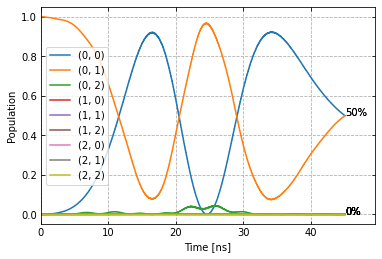

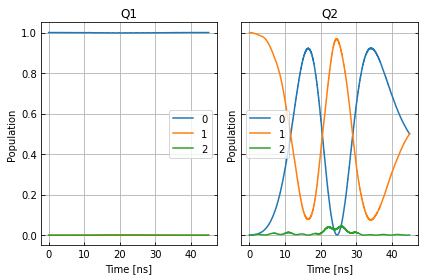

In [26]:
sequence = [gate_name]
plot_dynamics(exp, init_state, sequence)
plot_splitted_population(exp, init_state, sequence)

#### Open-loop optimal control

In [27]:
opt_gates = [gate_name]
exp.set_opt_gates(opt_gates)

gateset_opt_map=[
    [(gate_name, "d1", "carrier", "framechange")],
    [(gate_name, "d2", "carrier", "framechange")],
]

for (driver, envelope), sig_opt_params in \
    zip(drivers_signals, signals_opt_params):
    sig_name = envelope.name
    for param in sig_opt_params:
        gateset_opt_map.append([(gate_name, f"d{driver}", sig_name, 
                                 param),])


parameter_map.set_opt_map(gateset_opt_map)

parameter_map.print_parameters()

cx[0, 1]-d1-carrier-framechange       : 4.712 rad 
cx[0, 1]-d2-carrier-framechange       : 0.000 rad 
cx[0, 1]-d1-gauss0-amp                : 20.000 V 
cx[0, 1]-d1-gauss0-freq_offset        : -53.000 MHz 2pi 
cx[0, 1]-d1-gauss0-xy_angle           : -444.089 arad 
cx[0, 1]-d1-gauss0-delta              : -1.000  
cx[0, 1]-d2-gauss0-amp                : 20.000 V 
cx[0, 1]-d2-gauss0-freq_offset        : -53.000 MHz 2pi 
cx[0, 1]-d2-gauss0-xy_angle           : -444.089 arad 
cx[0, 1]-d2-gauss0-delta              : -1.000  



###### Control
Fidelity before optimization:

In [28]:
dims = [qubit_lvls, qubit_lvls]
ideal_gate = parameter_map.instructions[gate_name]\
    .get_ideal_gate(dims=dims)

In [29]:
1 - fidelities.unitary_infid(ideal_gate, exp.propagators[gate_name], 
                             dims=dims).numpy()[0]

0.34045797272925604

In [30]:
from c3.optimizers.optimalcontrol import OptimalControl

In [31]:
import os
import tempfile

# Create a temporary directory to store logfiles, modify as needed
log_dir = os.path.join(tempfile.TemporaryDirectory().name, "c3logs")
fid_func = lambda *args, **kwargs: fidelities.sparse_unitary_infid_set(*args, 
                                                                       reg_strength=5e-2*0,
                                                                       **kwargs)

lbfgs_options = {'maxfun': 50, 'maxiter': 50,  'iprint': 0, 'eps': 0, 
                 'gtol': 0, 'ftol': 0, 'maxls': 10**6, 'maxcor': 100}
cmaes_options = {'maxiter': 10**2}

opt = OptimalControl(
    dir_path=log_dir,
    fid_func=fid_func,
    fid_subspace=["Q1", "Q2"],
    pmap=parameter_map,
    algorithm=algorithms.lbfgs,
    options=lbfgs_options,
    run_name="opt_2q_gate"
)

In [ ]:
exp.set_opt_gates(opt_gates)
opt.set_exp(exp)
opt_res = opt.optimize_controls()

C3:STATUS:Saving as: C:\Users\YONATA~1\AppData\Local\Temp\tmpt8wnwkl_\c3logs\opt_2q_gate\2022_08_17_T_16_50_09\open_loop.c3log


C:\Users\Yonatan Gideoni\Desktop\ML4Q\c3\c3\utils\utils.py:64: UserWarning: OSError encountered while creating symlink
  warnings.warn("OSError encountered while creating symlink")
C:\Users\Yonatan Gideoni\Desktop\ML4Q\c3\c3\optimizers\optimizer.py:296: Warning: cx[0, 1]-d1-gauss0-delta has no gradient. This might indicate no usage for current experiment.
  warnings.warn(
C:\Users\Yonatan Gideoni\Desktop\ML4Q\c3\c3\optimizers\optimizer.py:296: Warning: cx[0, 1]-d2-gauss0-delta has no gradient. This might indicate no usage for current experiment.
  warnings.warn(


In [ ]:
print(f'Best objective cost: {opt.current_best_goal:.2e}')

Results for same gate sequence as before post-optimization:

In [ ]:
plot_dynamics(exp, init_state, sequence)

In [ ]:
plot_splitted_population(exp, init_state, sequence)

Optimal parameters and fidelity post-optimization:

In [ ]:
parameter_map.print_parameters()

In [ ]:
1 - fidelities.unitary_infid(ideal_gate, exp.propagators[gate_name], 
                             dims=dims).numpy()[0]

How the final signal looks:

In [ ]:
drivers_signals

In [ ]:
def plot_signal(drivers_signals: list, n_points: int= 1000):
    t_final = max(env.params['t_final'] for _, env in drivers_signals).numpy()
    signal_t = np.linspace(0, t_final, n_points)
    
    n_drivers = max(drivers_signals, key=lambda x: x[0])[0]
    res_signal = np.zeros((n_drivers, len(signal_t)), dtype=np.complex128)
    fig, axs = plt.subplots(1, n_drivers, sharey="all")

    for driver, env in drivers_signals:
        # de-normalize the amplitude so it has units of volts
        ts = awg.create_ts(0, t_final)
        env.normalize_pulse = False
        area = abs(env.get_shape_values(ts).numpy()).sum()
        amplitude = env.params['amp'].numpy()
        real_amplitude = amplitude / area
        
        signal = env.get_shape_values(signal_t).numpy() * real_amplitude
        res_signal[driver-1] += signal
        
        env.normalize_pulse = True

        axs[driver-1].plot(signal_t*1e9, np.real(signal), label=env.name)
    
    for driver in range(n_drivers):
        ax = axs[driver]
        
        ax.plot(signal_t*1e9, np.real(res_signal[driver]), 
                           label='Resulting signal', c='k', linewidth=2, linestyle='dashed')
        
        ax.set_title(f'Driver {driver+1}')
        ax.grid()
        ax.set_xlabel('Time[ns]')
        ax.set_ylabel('Signal[V]')
        ax.legend()
        ax.set_xlim(0, t_final*1e9)
    
    plt.suptitle('Real part of pulses')

In [ ]:
plot_signal(drivers_signals)

In [ ]:
print(opt_res.success)
print(opt_res.message)

Plotting the loss landscape and learning path:

In [ ]:
log_path = os.path.join(log_dir, 'opt_2q_gate')
while len(subdirs := os.listdir(log_path)) == 1:
    log_path = os.path.join(log_path, subdirs[0])

log_path = os.path.join(log_path, 'open_loop.c3log')

with open(log_path, 'r') as logs_file:
    logs_data = logs_file.read()

state_per_iteration = []
for line in logs_data.split('\n'):
    if line[0:9] != '{"params"':
        continue
    
    iteration_state = eval(line.strip().replace('null', 'np.nan'))
    state_per_iteration.append(iteration_state['params']+[iteration_state['goal']])

In [ ]:
def get_param_name(param_name):
    param_name = param_name[0]
    return param_name[param_name.index('-')+1:]
opt_params_names = [get_param_name(param_name) for param_name in parameter_map.get_opt_map()]
opt_params_names.append('goal')

In [ ]:
params_per_iter = pd.DataFrame(state_per_iteration, columns=opt_params_names)

In [ ]:
plot = True

In [ ]:
min_v = 0
max_v = 100
points_per_axis = 40

if not plot:
    res_infids = []
    for n_iter, gauss1_v in enumerate(np.linspace(min_v, max_v, 
                                                  points_per_axis)):
        if not plot:
            continue

        if n_iter % 5 == 0:
            print(f'{n_iter=}')

        parameter_map.instructions[gate_name].comps['d1']['gauss0']\
            .params['amp'].set_value(gauss1_v)
        for gauss2_v in np.linspace(min_v, max_v, points_per_axis):
            parameter_map.instructions[gate_name].comps['d2']['gauss0']\
                .params['amp'].set_value(gauss2_v)

            exp.compute_propagators()
            infid = fidelities.unitary_infid(ideal_gate, 
                                             exp.propagators[gate_name], 
                                             dims=dims).numpy()[0]

            res_infids.append({'v1': gauss1_v, 
                               'v2': gauss2_v, 
                               'infid': infid})

In [ ]:
if plot:
#     with open(f'infids_cache_{min_v}v_to_{max_v}v'
#               f'_{points_per_axis**2}points.pkl', 
#               'wb') as f:
#         pickle.dump(res_infids, f)
    
    with open(f'infids_cache_{min_v}v_to_{max_v}v'
              f'_{points_per_axis**2}points.pkl', 
              'rb') as f:
        res_infids = pickle.load(f)

In [ ]:
if plot:
    res_infids = pd.DataFrame.from_records(res_infids)

In [ ]:
if plot:
    ax = plt.figure().add_subplot(projection='3d')

    ax.plot_trisurf(res_infids.v1, res_infids.v2, res_infids.infid, 
                    linewidth=0.2, antialiased=True, cmap='jet')
    
    ax.set_xlabel('$V_1$')
    ax.set_ylabel('$V_2$')
    ax.set_zlabel('$1-F$')

In [ ]:
if plot:
    n_points_per_axis = 200
    
    v1 = np.linspace(res_infids.v1.min(), res_infids.v1.max(), n_points_per_axis)
    v2 = np.linspace(res_infids.v2.min(), res_infids.v2.max(), n_points_per_axis)
    v1, v2 = np.meshgrid(v1, v2)
    
    rbf = scipy.interpolate.Rbf(res_infids.v1, res_infids.v2, res_infids.infid, 
                                function='linear')
    infids = rbf(v1, v2)
    plt.imshow(infids, vmin=res_infids.infid.min(), vmax=res_infids.infid.max(), origin='lower',
               extent=[res_infids.v1.min(), res_infids.v1.max(), 
                       res_infids.v2.min(), res_infids.v2.max()], cmap='jet')
    
    params_per_iter.plot(x='d1-gauss0-amp', y='d2-gauss0-amp', ax=plt.gca(), c='k')
    params_per_iter.iloc[:1].plot.scatter(x='d1-gauss0-amp', y='d2-gauss0-amp', ax=plt.gca(), 
                                    c='g', zorder=10, s=50)
    params_per_iter.iloc[-1:].plot.scatter(x='d1-gauss0-amp', y='d2-gauss0-amp', ax=plt.gca(), 
                                    c='m', zorder=10, s=50)
    
    plt.xlabel('$V_1$')
    plt.ylabel('$V_2$')
    cbar = plt.colorbar()
    cbar.set_label('$1-F$')